In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

from Funciones import evaluar, evaluarDerivada

In [3]:
df_train = pd.read_csv(DATOS_DIR + 'optdigits_train.csv')
X_train = np.array(df_train.iloc[:,:-1]).astype(float)
Y_train = np.array(df_train.iloc[:,-1])

df_test = pd.read_csv(DATOS_DIR + 'optdigits_test.csv')
X_test = np.array(df_test.iloc[:,:-1]).astype(float)
Y_test = np.array(df_test.iloc[:,-1])

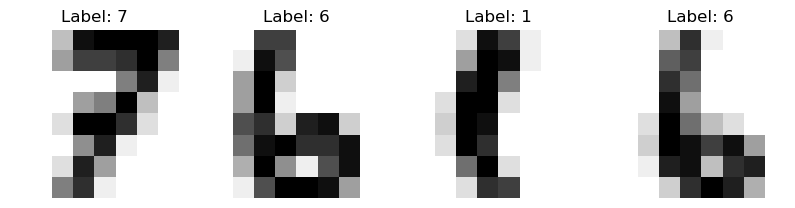

In [4]:
# visualizando algunos dígitos de df_train

# Selecciona 4 filas aleatorias del dataframe
sample_images = df_train.sample(4)

# Extrae las imágenes y las etiquetas (asumiendo que las etiquetas están en la última columna)
images = sample_images.iloc[:, :-1].values
labels = sample_images.iloc[:, -1].values

# Redimensiona las imágenes a 8x8
images = images.reshape((4, 8, 8))

# Crea una figura con 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap=plt.cm.gray_r) #cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

In [5]:
entradas = X_train.shape[1]
ocultas = 15

#-- la red tendrá una salida para cada dígito
salidas = 10
print("entradas = %d ; salidas = %d" % (entradas, salidas))

Y_trainB = np.zeros((len(Y_train), salidas))
for o in range(len(Y_train)):
    Y_trainB[o, Y_train[o]]=1
    
Y_testB = np.zeros((len(Y_test), salidas))
for o in range(len(Y_test)):
    Y_testB[o, Y_test[o]]=1

entradas = 64 ; salidas = 10


In [6]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre -1 y 1
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    

In [7]:
W1 = np.random.uniform(-0.5,0.5,[ocultas, entradas])
b1 = np.random.uniform(-0.5,0.5, [ocultas,1])
W2 = np.random.uniform(-0.5,0.5,[salidas, ocultas])
b2 = np.random.uniform(-0.5,0.5, [salidas,1])

In [8]:
FunH = 'sigmoid'
FunO = 'sigmoid'

if (FunO=='tanh'):
    Y_trainB = 2*Y_trainB -1
    Y_testB  = 2*Y_testB - 1

**Calculamos la salida del lote**

In [9]:
tamanioLote = 150
e=0

# propagar el LOTE hacia adelante
j = tamanioLote*e
xi = X_train[j:j+tamanioLote,:]     # Lote de ejemplos a ingresar a la red
yi = Y_trainB[j:j+tamanioLote, :]   # salidas esperadas para el Lote seleccionado
        
# propagar el LOTE hacia adelante
netasH = W1 @ xi.T + b1
netasH = W1 @ X_train[j:j+tamanioLote,:].T + b1
salidasH = evaluar(FunH, netasH)
netasO = W2 @ salidasH + b2
salidasO = evaluar(FunO, netasO)

print(f"xi: {xi.shape}, yi: {yi.shape}")
print(f"\nnetasH: {netasH.shape}, W1: {W1.shape}, xi.T: {xi.T.shape}, b1: {b1.shape}")
print(f"\nnetasO: {netasO.shape}, W2: {W2.shape}, salidasH: {salidasH.shape}, b2: {b2.shape}")
print(f"\nsalidasO: {salidasO.shape}")


xi: (150, 64), yi: (150, 10)

netasH: (15, 150), W1: (15, 64), xi.T: (64, 150), b1: (15, 1)

netasO: (10, 150), W2: (10, 15), salidasH: (15, 150), b2: (10, 1)

salidasO: (10, 150)


**Guardamos las correcciones de los pesos**

In [10]:
#-- errores en cada ejmplo del lote -- 
#-- matriz de SALIDAS x TAMANIOLOTE ---
ErroresSalida = yi.T-salidasO

#-- deltasO es una matriz de SALIDAS x TAMANIOLOTE ---
deltasO = ErroresSalida * evaluarDerivada(FunO,salidasO)

# deltasH es una matriz de OCULTAS x TAMANIOLOTE ---
deltasH = evaluarDerivada(FunH,salidasH)*((W2.T @ deltasO))

print(f"ErroresSalida: {ErroresSalida.shape}, yi.T: {yi.T.shape}, salidasO: {salidasO.shape}")
print(f"\ndeltasO: {deltasO.shape}, ErroresSalida: {ErroresSalida.shape}, salidasO: {salidasO.shape}")
print(f"\ndeltasH: {deltasH.shape}, salidasH: {salidasH.shape}, W2.T: {W2.T.shape}, deltasO: {deltasO.shape}, (W2.T @ deltasO): {(W2.T @ deltasO).shape}")


ErroresSalida: (10, 150), yi.T: (10, 150), salidasO: (10, 150)

deltasO: (10, 150), ErroresSalida: (10, 150), salidasO: (10, 150)

deltasH: (15, 150), salidasH: (15, 150), W2.T: (15, 10), deltasO: (10, 150), (W2.T @ deltasO): (15, 150)


**Corregimos los pesos promediando las correcciones**

In [11]:
alfa = 0.1

deltaO = np.sum(deltasO,axis=1).reshape(-1,1)
deltaH = np.sum(deltasH,axis=1).reshape(-1,1) 
        
W1 = W1 + alfa * deltasH @ xi 
b1 = b1 + alfa * deltaH 
W2 = W2 + alfa * deltasO @ salidasH.T 
b2 = b2 + alfa * deltaO 

print(f"W1: {W1.shape}, deltasH: {deltasH.shape}, xi: {xi.shape}, (deltasH @ xi): {(deltasH @ xi).shape}")
print(f"\nb1: {b1.shape}, deltaH: {deltaH.shape}")

print(f"\nW2: {W2.shape}, deltasO: {deltasO.shape}, salidasH.T: {salidasH.T.shape}, (deltasO @ salidasH.T): {(deltasO @ salidasH.T).shape}")
print(f"\nb2: {b2.shape}, deltaO: {deltaO.shape}")

W1: (15, 64), deltasH: (15, 150), xi: (150, 64), (deltasH @ xi): (15, 64)

b1: (15, 1), deltaH: (15, 1)

W2: (10, 15), deltasO: (10, 150), salidasH.T: (150, 15), (deltasO @ salidasH.T): (10, 15)

b2: (10, 1), deltaO: (10, 1)


In [12]:
nFilas = X_train.shape[0]

#alfa = 0.001
#CotaError = 1.0e-15
#MAX_ITERA = 800

alfa = 0.1
CotaError = 1.0e-4
MAX_ITERA = 400

ite = 0
errorAnt = 0
AVGError = 1
errores = []

# --- LOTE --------
tamanioLote = min(150, len(X_train))
nBloques = int(len(X_train)/tamanioLote)
# ------------------

print("Inicio ...")
tIni = time.time()

while ( abs(AVGError-errorAnt) > CotaError ) and ( ite < MAX_ITERA ):
    errorAnt = AVGError
    AVGError = 0
    for e in range(nBloques):   #para cada bloque
        # propagar el LOTE hacia adelante
        j = tamanioLote*e
        xi = X_train[j:j+tamanioLote,:]     # Lote de ejemplos a ingresar a la red
        yi = Y_trainB[j:j+tamanioLote, :]   # salidas esperadas para el Lote seleccionado
        
        # propagar el LOTE hacia adelante
        netasH = W1 @ xi.T + b1
        netasH = W1 @ X_train[j:j+tamanioLote,:].T + b1
        salidasH = evaluar(FunH, netasH)
        netasO = W2 @ salidasH + b2
        salidasO = evaluar(FunO, netasO)

        #-- errores en cada ejmplo del lote -- 
        #-- matriz de SALIDAS x TAMANIOLOTE ---
        ErroresSalida = yi.T-salidasO

        #-- deltasO es una matriz de SALIDAS x TAMANIOLOTE ---
        deltasO = ErroresSalida * evaluarDerivada(FunO,salidasO)
        deltaO = np.sum(deltasO,axis=1).reshape(-1,1)

        # deltasH es una matriz de OCULTAS x TAMANIOLOTE ---
        deltasH = evaluarDerivada(FunH,salidasH)*((W2.T @ deltasO))
        deltaH = np.sum(deltasH,axis=1).reshape(-1,1) 
        
        # corregir todos los pesos      
        W1 = W1 + alfa * deltasH @ xi 
        b1 = b1 + alfa * deltaH 
        W2 = W2 + alfa * deltasO @ salidasH.T 
        b2 = b2 + alfa * deltaO 

        AVGError = AVGError + np.mean(ErroresSalida**2)
    
    AVGError = AVGError / nBloques
    errores.append(AVGError)
    
    ite = ite + 1
    
tFin = time.time()
print("duración %.7f seg" % (tFin- tIni))

Inicio ...
duración 0.1465712 seg


In [21]:
print(f"nEj: {len(X_train)}, lote : {tamanioLote}, epocas : {len(errores)}, iteraciones: {len(errores)*nBloques}")

nEj: 3823, lote : 150, epocas : 32, iteraciones: 800


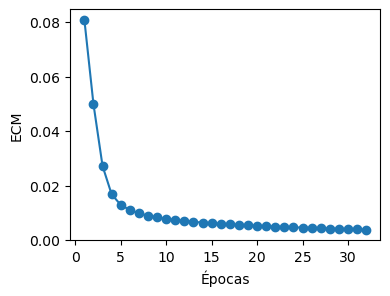

In [14]:
plt.figure(figsize=(4,3))
plt.plot(range(1, len(errores) + 1), errores, marker='o')
plt.xlabel('Épocas')
plt.ylabel('ECM')
plt.show()

In [15]:
# Respuesta de la red para los datos de ENTRENAMIENTO ---
NetasH = W1 @ X_train.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)
np.round(SalidasO[:, :5],3)

array([[0.986, 0.987, 0.   , 0.   , 0.016],
       [0.   , 0.   , 0.004, 0.09 , 0.   ],
       [0.001, 0.001, 0.022, 0.   , 0.   ],
       [0.   , 0.   , 0.009, 0.   , 0.002],
       [0.001, 0.004, 0.005, 0.582, 0.   ],
       [0.009, 0.003, 0.001, 0.   , 0.012],
       [0.001, 0.   , 0.   , 0.   , 0.898],
       [0.   , 0.   , 0.992, 0.011, 0.   ],
       [0.   , 0.   , 0.   , 0.007, 0.007],
       [0.001, 0.001, 0.005, 0.291, 0.   ]])

In [16]:
Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_train,Y_pred))

% aciertos X_train : 0.984


In [17]:
report = metrics.classification_report(Y_train,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       376
           1       0.95      0.99      0.97       389
           2       0.99      1.00      0.99       380
           3       0.99      0.98      0.99       389
           4       0.99      0.98      0.99       387
           5       0.98      0.99      0.98       376
           6       0.99      0.99      0.99       377
           7       1.00      0.99      1.00       387
           8       0.99      0.94      0.96       380
           9       0.97      0.98      0.98       382

    accuracy                           0.98      3823
   macro avg       0.98      0.98      0.98      3823
weighted avg       0.98      0.98      0.98      3823



In [18]:
MM = metrics.confusion_matrix(Y_train,Y_pred)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[374   0   0   0   1   0   1   0   0   0]
 [  0 384   0   0   0   1   1   0   0   3]
 [  0   0 379   0   0   0   1   0   0   0]
 [  0   1   0 383   0   2   0   0   0   3]
 [  1   2   0   0 381   0   2   0   0   1]
 [  0   0   1   1   0 372   0   0   0   2]
 [  0   1   1   0   1   0 374   0   0   0]
 [  0   0   0   2   0   0   0 385   0   0]
 [  0  16   1   0   1   5   0   0 356   1]
 [  0   2   0   1   2   0   0   1   2 374]]


In [19]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(Y_test,Y_pred))

report = metrics.classification_report(Y_test, Y_pred)
print("Confusion matrix Test:\n%s" % report) 

MM = metrics.confusion_matrix(Y_test, Y_pred)
print("Confusion matrix:\n%s" % MM)

% aciertos X_test : 0.949

Confusion matrix Test:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       178
           1       0.89      0.96      0.92       182
           2       0.96      0.99      0.98       177
           3       0.96      0.95      0.95       183
           4       0.98      0.97      0.98       181
           5       0.92      0.96      0.94       182
           6       0.98      0.98      0.98       181
           7       0.99      0.93      0.96       179
           8       0.97      0.83      0.90       174
           9       0.88      0.96      0.92       180

    accuracy                           0.95      1797
   macro avg       0.95      0.95      0.95      1797
weighted avg       0.95      0.95      0.95      1797

Confusion matrix:
[[171   0   0   0   2   3   2   0   0   0]
 [  0 174   2   0   0   1   0   0   0   5]
 [  0   1 176   0   0   0   0   0   0   0]
 [  0   1   3 173   0   1   0   1   0   4]
 

In [20]:
Y_train[:5]


array([0, 0, 7, 4, 6], dtype=int64)